# Preparação do ambiente

### Importação das Bibliotecas

In [4]:
# Importando bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
import os

### Definição do caminho do dataset

In [5]:
APP_DIRECTORY = os.getcwd()

# Nomes padrões
DATA_DIRECTORY = 'data'
FILE_NAME = 'heart_2022_no_nans.csv'

# Definindo o caminho da base de dados dentro do projeto
FILE_PATH = os.path.join(DATA_DIRECTORY, FILE_NAME)

# Definindo o caminho completo para o arquivo 'heart_2022_no_nans.csv'
FULL_FILE_PATH = os.path.join(APP_DIRECTORY, FILE_PATH)

# Leitura do Dataset

Em primeiro lugar, começa-se carregando o dataset obtido do [Kaggle](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/data?select=2022). O comando _set_option('display.max_columns', None)_ do Pandas determina que todas as colunas da base devem ser mostradas por default, a não ser que o contrário seja especificado.

In [6]:

# Define que pandas deve exibir todas as colunas
pd.set_option('display.max_columns', None)  

# Abrir o dataset
print(f"Abrindo base de dados em {FULL_FILE_PATH}")
heart_data_original = pd.read_csv(FULL_FILE_PATH, encoding='unicode_escape')
heart_data_original.head()  # Visualizando as primeiras linhas

Abrindo base de dados em c:\Users\masar\Documents\UFF\Oitavo Semestre\IA\IACardio\app\data\heart_2022_no_nans.csv


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 65 to 69,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,No,No,No,No,No,No,No,Yes,Yes,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 70 to 74,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,No,No,No,No,No,No,No,Yes,No,No,Yes,No,Yes,No,No,Former smoker,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 75 to 79,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,No,No,Yes,No,Yes,No,Yes,No,No,No,No,Yes,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 80 or older,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


## Visualização inicial dos dados

Em seguida, podemos extrair algumas informações das colunas da nossa base.

In [7]:
heart_data_original.info()  # coletando informações das colunas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

Ao todo, existem 40 atributos no dataset, sendo 6 deles de tipos numéricos (indicados com float64). São eles:
- PhysicalHealthDays
- MentalHealthDays
- SleepHours
- HeightInMeters
- WeightInKilograms
- BMI

A descrição de cada atributo, [de acordo com a pesquisa feita pelo CDC](https://www.cdc.gov/brfss/annual_data/annual_2022.html), pode ser encontrada na tabela a seguir.

| Atributo                  | Descrição |
|:-------------------------:|:--------------------------------------------------------------------------------------------------------------------- |
| State                     | Estado (dos EUA) em que reside                                                                                        |
| Sex                       | Sexo biológico                                                                                                        |
| GeneralHealth             | Como a pessoa classifica sua saúde geral                                                                              |
| PhysicalHealthDays        | Por quantos dias dentre os 30 dias anteriores a saúde física da pessoa NÃO esteve boa                                  |
| MentalHealthDays          | Por quantos dias dentre os 30 dias anteriores a saúde mental da pessoa NÃO esteve boa                                  |
| LastCheckupTime           | Quando foi a última visita a um médico para checagem                                                                  |
| PhysicalActivities        | Se a pessoa praticou alguma atividade física nos 30 dias anteriores                                                   |
| SleepHours                | Tempo médio de sono                                                                                                   |
| RemovedTeeth              | Quantas vezes um dente permanente da pessoa teve de ser retirado por problemas dentários                              |
| HadHeartAttack            | Se já teve um infarto do miocárdio                                                                                    |
| HadAngina                 | Se já teve angina ou doença arterial coronariana (DAC)                                                                |
| HadStroke                 | Se já teve um acidente vascular cerebral (AVC)                                                                        |
| HadAsthma                 | Se já teve asma                                                                                                       |
| HadSkinCancer             | Se já teve câncer de pele que não fosse um melanoma                                                                   |
| HadCOPD                   | Se já teve doença pulmonar obstrutiva crônica (DPOC) ou bronquite crônica                                             |
| HadDepressiveDisorder     | Se já teve distúrbio depressivo                                                                                       |
| HadKidneyDisease          | Se já teve doença nos rins que não fosse pedras nos rins, incontingência urinária ou infeccção urinária               |
| HadArthritis              | Se já teve algum tipo de artrite                                                                                      |
| HadDiabetes               | Se já teve diabetes                                                                                                   |
| DeafOrHardOfHearing       | Se possui surdez ou alguma dificuldade auditiva                                                                       |
| BlindOrVisionDifficulty   | Se possui cegueira ou alguma dificuldade em enxergar (mesmo com óculos)                                               |
| DifficultyConcentrating   | Se possui alguma dificuldade de concentração ou memória                                                               |
| DifficultyWalking         | Se possui alguma dificuldade ao andar ou subir escadas                                                                |
| DifficultyDressingBathing | Se possui alguma dificuldade ao se vestir ou se banhar                                                                |
| DifficultyErrands         | Se possui alguma dificuldade em realizar tarefas cotidianas em virtude de alguma condição física, mental ou emocional |
| SmokerStatus              | Uso de cigarro comum                                                                                                  |
| ECigaretteUsage           | Uso de cigarro eletrônico                                                                                             |
| ChestScan                 | Se já fez alguma tomografia computadorizada da região do peito                                                        |
| RaceEthnicityCategory     | Raça/etnia autodeclarada                                                                                              |
| AgeCategory               | Idade (discretizada em categorias)                                                                                    |
| HeightInMeters            | Altura em metros                                                                                                      |
| WeightInKilograms         | Massa corporal em quilogramas                                                                                         |
| BMI                       | Índice de Massa Corporal (IMC)                                                                                        |
| AlcoholDrinkers           | Se consome bebidas alcoólicas regularmente                                                                            |
| HIVTesting                | Se alguma vez já fez teste para HIV                                                                                 |
| FluVaxLast12              | Se foi vacinado contra a gripe nos últimos 12 meses                                                                   |
| PneumoVaxEver             | Se alguma vez já foi vacinado contra pneumonia                                                                        |
| TetanusLast10Tdap         | Se foi vacinado contra tétano nos últimos 10 anos                                                                     |
| HighRiskLastYear          | Se a pessoa se envolveu em alguma das situações de alto risco a seguir no ano anterior: drogas ilícitas injetáveis; tratamento para alguma DST; pagamento ou recebimento de dinheiro ou droga em troca de favores sexuais.                                                         |
| CovidPos                  | Se já testou positivo para COVID-19                                                                                   |

# Pré-processamento

Nesta seção, realizamos o pré-processamento dos dados do dataset. É possível destacar as atividades de remoção de colunas irrelevantes, ajustes em variáveis categóricas, e criação de novas colunas derivadas de outras já existentes. Antes de mais nada, porém, criemos uma cópia separado do Dataframe original para aplicar o pré-processamento, a fim de se manter o original para eventuais comparações.

In [8]:
heart_data = heart_data_original.copy()  # copiando o dataset para outro objeto

### Checagem e remoção dos nulos

Como o dataset já havia recebido um pré-tratamento inicial pelo divulgador, não há colunas nulas no dataset. 

In [9]:
heart_data.isna().values.any()

False

Logo, é possível pular a etapa de remoção das amostras com atributos nulos.

### Ajuste de variáveis

A seguir, realizamos a conversão de algumas variáveis para simplificar as classes de alguns atributos, reduzindo seu número e complexidade para o modelo ou simplesmente facilitando o entendimento humano.

In [10]:
# DIABETES: SOMENTE SIM, NÃO, BORDERLINE OU DURANTE GRAVIDEZ
heart_data['HadDiabetes'] = heart_data['HadDiabetes'].replace(
    {
        'No, pre-diabetes or borderline diabetes': 'Borderline', 
        'Yes, but only during pregnancy (female)': 'During Pregnancy'
    }
)
heart_data['HadDiabetes'].unique()

array(['No', 'Yes', 'During Pregnancy', 'Borderline'], dtype=object)

In [11]:
# SMOKER: NEVER, FORMER SMOKER, SOME DAYS, EVERY DAY
heart_data['SmokerStatus'] = heart_data['SmokerStatus'].replace(
    {
        'Current smoker - now smokes some days': 'Some days', 
        'Current smoker - now smokes every day': 'Everyday',
        'Never smoked': 'Never'
    }
)
heart_data['SmokerStatus'].unique()

array(['Former smoker', 'Never', 'Everyday', 'Some days'], dtype=object)

In [12]:
# E-CIGARETTE: NOT ANYMORE, NEVER, EVERYDAY, SOMEDAYS
heart_data['ECigaretteUsage'] = heart_data['ECigaretteUsage'].replace(
    {
        'Never used e-cigarettes in my entire life': 'Never', 
        'Not at all (right now)': 'Former smoker', 
        'Use them some days': 'Some days',
        'Use them every day': 'Everyday',
    }
)
heart_data['ECigaretteUsage'].unique()

array(['Never', 'Some days', 'Former smoker', 'Everyday'], dtype=object)

In [13]:
# COVID: SOMENTE SIM OU NÃO
heart_data['CovidPos'] = heart_data['CovidPos'].replace(
    {
        'Tested positive using home test without a health professional': 'Yes'
    }
)
heart_data['CovidPos'].unique()

array(['No', 'Yes'], dtype=object)

In [14]:
# FAIXA ETÁRIA: SIMPLIFICAÇÃO DAS VARIÁVEIS EM XX-XX ou 80+
heart_data['AgeCategory'] = heart_data['AgeCategory'].replace(
    {
        'Age 80 or older': '80+'
    }
)
for value in heart_data['AgeCategory'].unique():
    value = str(value)
    if value != 'nan' and value != '80+':
        cat_value = value.split(" ")
        heart_data['AgeCategory'] = heart_data['AgeCategory'].replace(
            {
                value: cat_value[1] + "-" + cat_value[3]
            }
        )
heart_data['AgeCategory'].unique()

array(['65-69', '70-74', '75-79', '80+', '50-54', '40-44', '60-64',
       '55-59', '45-49', '35-39', '25-29', '30-34', '18-24'], dtype=object)

In [15]:
# Raça/Etnia reduzida a 4 opções
heart_data['RaceEthnicityCategory'] = heart_data['RaceEthnicityCategory'].replace(
    {
        'White only, Non-Hispanic': 'White',
        'Black only, Non-Hispanic': 'Black', 
        'Other race only, Non-Hispanic': 'Other Race', 
        'Multiracial, Non-Hispanic': 'Multi Racial'
    }
)
heart_data['RaceEthnicityCategory'].unique()

array(['White', 'Black', 'Other Race', 'Multi Racial', 'Hispanic'],
      dtype=object)

### Ajuste de colunas

Algumas colunas contidas no dataset são irrelevantes para a pergunta que se deseja responder e podem acabar impactando negativamente na acurácia do modelo, tornando-o parcial para alguma classe. A fim de se evitar esse problema, algumas podem ser removidas.

In [16]:
heart_data = heart_data.drop(
    columns=[
        'State',
        'RemovedTeeth',
        'LastCheckupTime',
        'ChestScan',
        'HIVTesting',
        'FluVaxLast12',
        'PneumoVaxEver', 
        'TetanusLast10Tdap',
        'HeightInMeters',
        'WeightInKilograms',
    ]
)
heart_data.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,RaceEthnicityCategory,AgeCategory,BMI,AlcoholDrinkers,HighRiskLastYear,CovidPos
0,Female,Very good,4.0,0.0,Yes,9.0,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Former smoker,Never,White,65-69,27.99,No,No,No
1,Male,Very good,0.0,0.0,Yes,6.0,No,No,No,No,No,No,No,No,Yes,Yes,No,No,No,No,No,No,Former smoker,Never,White,70-74,30.13,No,No,No
2,Male,Very good,0.0,0.0,No,8.0,No,No,No,No,No,No,No,No,Yes,No,No,Yes,No,Yes,No,No,Former smoker,Never,White,75-79,31.66,Yes,No,Yes
3,Female,Fair,5.0,0.0,Yes,9.0,No,No,No,No,Yes,No,Yes,No,Yes,No,No,No,No,Yes,No,No,Never,Never,White,80+,31.32,No,No,Yes
4,Female,Good,3.0,15.0,Yes,5.0,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Never,Never,White,80+,33.07,No,No,No


Eis a justificativa de cada uma delas

- **State**: A localização geográfica (estado) pode ter uma correlação indireta com doenças cardíacas devido a fatores como acesso a cuidados de saúde, prevalência de certos estilos de vida e condições socioeconômicas. No entanto, é um indicador muito genérico e pode introduzir viés se não for combinado com dados mais específicos sobre o estilo de vida ou condições socioeconômicas individuais.

- **RemovedTeeth**: A perda de dentes pode indicar problemas de saúde bucal passados ou presentes, que têm sido associados a doenças cardíacas em alguns estudos. No entanto, essa relação é complexa e pode ser influenciada por muitos outros fatores, tornando-a uma variável menos direta para prever doenças cardíacas.

- **LastCheckupTime**: O tempo desde o último check-up pode indicar a frequência com que uma pessoa procura cuidados preventivos de saúde, o que pode ter uma relação com o risco de doenças cardíacas. No entanto, essa variável por si só não fornece informações sobre a condição de saúde atual ou histórico médico específico.

- **ChestScan**: Exames de imagem do tórax podem detectar condições que indicam risco de doença cardíaca, mas a presença dessa variável no conjunto de dados não indica os resultados desses exames, apenas se foram realizados ou não, o que por si só é insuficiente para avaliar o risco de doença cardíaca.

- **HIVTesting**: O teste de HIV pode ser relevante para a saúde geral, mas não tem uma relação direta com doenças cardíacas. A menos que o resultado do teste e informações sobre a condição de saúde relacionada ao HIV estejam disponíveis, essa variável por si só não contribui diretamente para a previsão de doenças cardíacas.

- **FluVaxLast12**: A vacinação contra a gripe tem sido associada a um menor risco de eventos cardiovasculares em algumas pesquisas, mas essa relação pode não ser direta e é influenciada por muitos outros fatores, tornando-a uma variável menos específica para prever doenças cardíacas.

- **PneumoVaxEver**: Semelhante à vacinação contra a gripe, a vacinação contra pneumonia pode ter um impacto indireto na saúde cardíaca, mas a relação não é direta e pode ser confundida por outros fatores, como condições de saúde subjacentes que levam à recomendação da vacina.

- **TetanusLast10Tdap**: A vacinação contra tétano, difteria e coqueluche (Tdap) é importante para a saúde geral, mas não tem uma relação direta com o risco de doenças cardíacas, tornando-a menos relevante para este contexto específico.

- **HeightInMeters** e **WeightInKilograms**: Por ser calculado em função da altura e do peso, o IMC já resume bem esses dados e mantê-los seria uma redundância.

Além disso, podemos derivar uma nova coluna **SmokingHabit** que resume as colunas **SmokerStatus** e **ECigaretteUsage**, de forma que uma pessoa é considerada fumante se fuma qualquer cigarro, seja cigarro normal ou eletrônico.

In [17]:
heart_data['SmokerStatus'] = heart_data['SmokerStatus'].replace(
    {
        'Everyday': 'Smoker',
        'Some days': 'Smoker'
    }
)
heart_data['ECigaretteUsage'] = heart_data['ECigaretteUsage'].replace(
    {
        'Everyday': 'Smoker',
        'Some days': 'Smoker'
    }
)

# Condições para definir a nova coluna 'SmokingHabit'
conditions = [
    (heart_data['ECigaretteUsage'] == 'Smoker') | (heart_data['SmokerStatus'] == 'Smoker'),
    (heart_data['ECigaretteUsage'] == 'Former smoker') | (heart_data['SmokerStatus'] == 'Former smoker')
]

# Escolhas correspondentes a cada condição
choices = [
    'Smoker',
    'Former smoker'
]

# Aplicando np.select para definir os valores na nova coluna 'SmokingHabit'
# 'Never' é o valor padrão se nenhuma condição for verdadeira
heart_data['SmokingHabit'] = np.select(conditions, choices, default='Never')
  
heart_data = heart_data.drop(columns=['SmokerStatus', 'ECigaretteUsage'])

### Impressão das classes de cada variável após as tratamento

In [18]:
# Printa as variáveis de cada classe após as simplificações
for col in heart_data.describe(include='object').columns:
    print('Column Name: ', col)
    print(heart_data[col].unique())
    print('-' * 50)

Column Name:  Sex
['Female' 'Male']
--------------------------------------------------
Column Name:  GeneralHealth
['Very good' 'Fair' 'Good' 'Excellent' 'Poor']
--------------------------------------------------
Column Name:  PhysicalActivities
['Yes' 'No']
--------------------------------------------------
Column Name:  HadHeartAttack
['No' 'Yes']
--------------------------------------------------
Column Name:  HadAngina
['No' 'Yes']
--------------------------------------------------
Column Name:  HadStroke
['No' 'Yes']
--------------------------------------------------
Column Name:  HadAsthma
['No' 'Yes']
--------------------------------------------------
Column Name:  HadSkinCancer
['No' 'Yes']
--------------------------------------------------
Column Name:  HadCOPD
['No' 'Yes']
--------------------------------------------------
Column Name:  HadDepressiveDisorder
['No' 'Yes']
--------------------------------------------------
Column Name:  HadKidneyDisease
['No' 'Yes']
-----------

### Remoção de Entradas Duplicadas

Removemos entradas duplicadas para garantir que cada observação no dataset seja única.


In [19]:
heart_data = heart_data.drop_duplicates()

### Encoding

#### One Hot Encoding

Para variáveis categóricas que não possuem uma relação de ordem ou gradação entre suas classes, aplica-se o **One-Hot Encoding**, em que a variável é transformada num conjunto de novas variáveis booleanas baseadas nas suas classes.

In [20]:

# Cria uma instância do codificador
one_hot_encoder = OneHotEncoder(drop=None, dtype=int)

# Seleciona as colunas desejadas para aplicar o OneHotEncoding
one_hot_columns = ['Sex', 'RaceEthnicityCategory']

# Aplica o fit_transform para transformar as colunas selecionadas
one_hot_data = one_hot_encoder.fit_transform(heart_data[one_hot_columns]).toarray()

# Converte o resultado para um DataFrame
one_hot_df = pd.DataFrame(one_hot_data, columns=one_hot_encoder.get_feature_names_out())

# Remove as colunas originais do DataFrame
heart_data = heart_data.drop(columns=one_hot_columns)

# Resetando index para evitar problemas na concatenação
heart_data.reset_index(drop=True, inplace=True)
one_hot_df.reset_index(drop=True, inplace=True)

# Junta o DataFrame original com as novas colunas codificadas
heart_data = pd.concat([heart_data, one_hot_df], axis=1)

#### Oridnal Encoding

Para variáveis categóricas que possuem alguma relação de ordem e gradação entre suas classes (ou variáveis binárias que podem ser traduzidas com booleanas), aplica-se o **Ordinal Encoding**, em que a variável é traduzida pelo mapeamento de cada uma das suas categorias a um número, respeitando a ordem/gradação das categorias.

In [21]:
# ordinal_encode_columns = [
#     'GeneralHealth', # O
#     'PhysicalActivities', # O
#     'HadHeartAttack', # O
#     'HadAngina', # O
#     'HadStroke', # O
#     'HadAsthma', # O
#     'HadSkinCancer', # O
#     'HadCOPD', # O
#     'HadDepressiveDisorder', # O
#     'HadKidneyDisease', # O 
#     'HadArthritis', # O
#     'HadDiabetes', # O
#     'DeafOrHardOfHearing', # O
#     'BlindOrVisionDifficulty', # O
#     'DifficultyConcentrating', # O
#     'DifficultyWalking', # O
#     'DifficultyDressingBathing', # O 
#     'DifficultyErrands', # O
#     'AgeCategory', # O
#     'BMI', # O
#     'AlcoholDrinkers', # O
#     'HighRiskLastYear', # O
#     'CovidPos', # O
#     'SmokingHabit', # O
# ]

# TODO: Completar com o restante das colunas
ordinal_encode_columns = [
    'GeneralHealth',
    'PhysicalActivities',
    'HadHeartAttack',
]
# TODO: Completar com o restante da ordenação das respostas
encode_order = [
    ['Excellent', 'Very good', 'Good', 'Fair', 'Poor'],
    ['Yes', 'No'],
    ['No', 'Yes'],
]

ordinal_encoder = OrdinalEncoder(categories=encode_order)

ordinal_encoded_data = ordinal_encoder.fit_transform(heart_data[ordinal_encode_columns])

ordinal_df = pd.DataFrame(ordinal_encoded_data, columns=ordinal_encoder.get_feature_names_out())

# Remove as colunas originais do DataFrame
heart_data = heart_data.drop(columns=ordinal_encode_columns)

# Resetando index para evitar problemas na concatenação
heart_data.reset_index(drop=True, inplace=True)
one_hot_df.reset_index(drop=True, inplace=True)

# Junta o DataFrame original com as novas colunas codificadas
heart_data = pd.concat([heart_data, one_hot_df], axis=1)

# Matriz de Correlação

Calculamos a matriz de correlação de Pearson para verificar a correlação entre as variáveis do dataset.


In [23]:
# Calcular a matriz de correlação de Pearson
correlation_matrix = heart_data.corr(method='pearson')

# Plotar a matriz de correlação como um mapa de calor
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
# plt.title('Matriz de Correlação de Pearson')
# plt.show()

ValueError: could not convert string to float: 'No'

**Correlação alta**

- HadHeartAttack tem uma correlação moderada positiva com HadStroke (0.18), HadAngina (0.45), e HadCOPD (0.17). Isso sugere que pessoas que tiveram um ataque cardíaco também têm maior probabilidade de ter tido um derrame, angina ou COPD.
HadStroke também está correlacionado com HadCOPD (0.20), indicando que esses eventos de saúde podem ocorrer juntos em alguns pacientes.

**Correlação negativa**

- PhysicalActivities tem uma correlação negativa moderada com DifficultyWalking (-0.26), DifficultyDressingBathing (-0.24), DifficultyErrands (-0.22), e DifficultyConcentrating (-0.16). Isso sugere que pessoas com mais atividades físicas tendem a ter menos dificuldades físicas.

**Interpretação de correlações específicas**

- GeneralHealth tem correlações moderadas com HadDepressiveDisorder (0.42), HadCOPD (0.30), e HadArthritis (0.31), indicando que a saúde geral autoavaliada é influenciada por essas condições.
HadDepressiveDisorder tem uma correlação moderada com GeneralHealth (0.42), o que sugere que a presença de distúrbios depressivos pode afetar negativamente a percepção de saúde geral.
Variáveis com correlação quase nula:

- Variáveis como Sex, AgeCategory, e RaceEthnicityCategory têm correlações muito baixas com a maioria das outras variáveis, sugerindo que elas têm pouca influência linear direta sobre as outras variáveis medidas no dataset.

# Separação dos Conjuntos Treino e Teste

- **Conjunto de Treino**: Contém 70% dos dados e é usado para treinar o modelo.
- **Conjunto de Teste**: Contém 30% dos dados e é usado para avaliar a performance do modelo em dados não vistos durante o treinamento.
train_test_split: Função do scikit-learn que facilita essa separação. O parâmetro random_state=42 é usado para garantir a reprodutibilidade dos resultados.

- A proporção de 70/30 ou 80/20 é comum porque oferece um bom equilíbrio entre ter dados suficientes para treinar o modelo e dados suficientes para testar a performance do modelo.

In [ ]:
# Separa classe alvo e as restantes
x = heart_data.drop('HadHeartAttack', axis=1)
y = heart_data['HadHeartAttack']

# Separa conjunto de treino e conjunto de teste
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.70, random_state=42)

# Transforma o vetor de destino y para ter uma dimensão unidimensional
y_train = np.ravel(ytrain)


# Undersampling do Dataset

- **RandomUnderSampler**: Este método reduz o número de instâncias da classe majoritária para igualar o número de instâncias da classe minoritária, resultando em um dataset balanceado.
- **Random State**: Garante reprodutibilidade dos resultados.
- **Normalização dos Dados**: StandardScaler é usado para normalizar os dados, o que é uma prática comum antes de aplicar muitos algoritmos de aprendizado de máquina, especialmente aqueles que são sensíveis à escala dos dados, como regressão logística e SVM.

In [ ]:
# Undersampling para balanceamento da classe alvo
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(x, y)
print(pd.Series(y_resampled).value_counts())


HadHeartAttack
0    13429
1    13429
Name: count, dtype: int64


# Normalização dos dados

In [ ]:
# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# K-fold Crossvalidation

- **Redução do Overfitting**:
Ao usar múltiplos folds, K-Fold Cross-Validation minimiza a tendência do modelo de superestimar sua própria performance, proporcionando uma avaliação mais precisa da sua capacidade de generalização. 
Fontes como "Pattern Recognition and Machine Learning" de Christopher Bishop discutem a importância de técnicas de validação cruzada para evitar overfitting.

- **Utilização Completa do Dataset**:
Cada observação no dataset é usada tanto para treinamento quanto para teste. 
Isso maximiza o uso dos dados disponíveis, especialmente útil em datasets pequenos, como destacado em "The Elements of Statistical Learning" de Hastie, Tibshirani e Friedman.

- **Estimativa Robusta da Performance do Modelo**:
K-Fold Cross-Validation fornece uma estimativa mais robusta da performance do modelo, já que o resultado final é a média dos resultados de todos os folds. 
Isso reduz a variação que pode resultar de uma única divisão dos dados, como discutido em "Introduction to Statistical Learning" pelos mesmos autores.

- **Desempenho Comparativo**:
Permite a comparação eficaz entre diferentes modelos e parâmetros, utilizando a mesma estrutura de dados. 
Este método é essencial para selecionar o melhor modelo e ajustes de hiperparâmetros, como abordado em "Applied Predictive Modeling" por Kuhn e Johnson.

- **Parâmetros Específicos**:

* **Número de Folds (n_splits=10)**: 10 é um valor comum que proporciona um bom equilíbrio entre viés e variância na estimativa da performance do modelo.
    * Shuffle=True: Mistura os dados antes de dividi-los em folds, garantindo que cada fold seja representativo da distribuição geral dos dados.
    * Random State: Garante reprodutibilidade dos resultados ao manter a consistência na forma como os dados são embaralhados e divididos em folds.

In [ ]:
# K-Fold Cross-Validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Cálculo do K ótimo

In [ ]:
# Assumindo que seus dados estão armazenados em X_scaled e y_resampled
# Range de valores K para testar
k_range = range(1, 45)
k_scores = []


# Avaliar o KNN para cada valor de K usando validação cruzada
for k in k_range:
   knn = KNeighborsClassifier(n_neighbors=k)
   scores = cross_val_score(knn, X_scaled, y_resampled, cv=10, scoring='accuracy')
   k_scores.append(scores.mean())

# # Plotar a acurácia para cada valor de K
# plt.figure(figsize=(8, 4))
# plt.plot(k_range, k_scores, 'bo-')
# plt.xlabel('Número de Vizinhos K')
# plt.ylabel('Acurácia')
# plt.title('Número ótimo de K para o KNN')
# plt.show()

# Melhor valor de K
optimal_k = k_range[np.argmax(k_scores)]
print(f'The optimal number of neighbors is {optimal_k}') 

The optimal number of neighbors is 35


# Avaliação dos Modelos

1. **Acurácia**: Proporção de previsões corretas.
2. **Precisão**: Proporção de verdadeiros positivos entre as previsões positivas.
3. **Recall**: Proporção de verdadeiros positivos entre os casos positivos reais.
4. **F1-Score**: Média harmônica da precisão e recall.
5. **ROC AUC**: Área sob a curva ROC, que mede a capacidade do modelo em distinguir entre as classes.

### Definição das métricas

In [ ]:
metricas = {
        'accuracy': metrics.make_scorer(metrics.accuracy_score),
        'precision': metrics.make_scorer(metrics.precision_score, average='weighted'),
        'recall': metrics.make_scorer(metrics.recall_score, average='weighted'),
        'f1_score': metrics.make_scorer(metrics.f1_score, average='weighted'),
        'roc_auc': metrics.make_scorer(metrics.roc_auc_score, average='weighted', needs_proba=True, multi_class='ovr')
    }

### Função para calcular métricas

In [ ]:
# Função para calcular métricas
def evaluate_model(model, X, y, metricas):
    results = {}
    for metric_name, metric in metricas.items():
        scores = cross_val_score(model, X, y, cv=kfold, scoring=metric)
        results[metric_name] = scores
    return results

### Definição dos modelos

In [ ]:
# Modelos
models = {
    'KNN': KNeighborsClassifier(n_neighbors=optimal_k),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier()
}
    #'Random Forest': RandomForestClassifier()

NameError: name 'KNeighborsClassifier' is not defined

### Avaliação dos Modelos com K-Fold

In [ ]:
# Avaliação dos Modelos com K-Fold
results = {}

for name, model in models.items():
    model_results = evaluate_model(model, X_scaled, y_resampled, metricas)
    results[name] = model_results
    print(f'{name}:')
    for metric_name, scores in model_results.items():
        print(f'  {metric_name}: {scores.mean():.4f} (+/- {scores.std():.4f})')

# Comparação Final dos Modelos
result_df = pd.DataFrame({metric: {model: results[model][metric].mean() for model in models} for metric in metrics}) # FIXME! Não está conseguindo iterar nas métricas
print(result_df)

NameError: name 'models' is not defined

c:\Users\masar\Documents\UFF\Oitavo Semestre\IA\IACardio\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


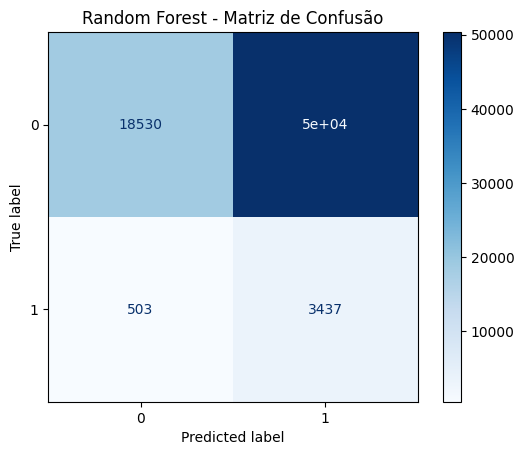

In [ ]:
# Treinando o modelo Random Forest com todos os dados
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_scaled, y_resampled)

# Predições no conjunto de teste
y_pred = rf_model.predict(xtest)

# Calculando a matriz de confusão
cm = metrics.confusion_matrix(ytest, y_pred)

# Exibindo a matriz de confusão
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Random Forest - Matriz de Confusão')
plt.show()
